# Logical Pauli operations in an error-detecting repetition code

We implement the [[3, 1, 3]] 3-qubit repetition code capable of detecting up to 2 bit-flip errors. Following the spirit of [Marques et al.](https://www.nature.com/articles/s41567-021-01423-9.pdf), we attempt to evaluate the repetition code's performance on Quantum Inspire's 5-qubit Starmon-5 device. Specifically, we attempt to analyze the performance of logical Pauli operations as depicted in Figures 2c and 2e of the paper.

Unfortunately, our attempt does not yield meaningful results. The logical Pauli measurements performed on the quantum device do not follow the expected trends. We tested our implementation using the `QX single-node simulator`, which gave the correct syndrome measurements and reproduced the expected trends. We suspect a few reasons for this:

1. Other error types (phase-flip errors, dissipative effects, etc) dominate over bit-flip errors. 

2. Due to the topology of Starmon, multiple `SWAP` gates were introduced in order to implement certain 2-qubit gates, which increased the circuit depth and hence the errors.

3. A software bug was introduced when interfacing with the quantum device. In particular, the Qiskit to cQASM interface seemed a little finnicky.

Although we are aware that the repetition code is capable of correcting single bit-flip errors after detection, we did not attempt it here since we were unfamiliar with its implementation on Starmon. Instead, we simply post-selected on the syndrome qubit measurements that yielded zero error during data processing.

## The 3-qubit repetition code
The 3-qubit repetition code is capable of encoding 1 logical qubit using 3 physical qubits. In the stabilizer formalism, it is defined by the following stabilizers:
\begin{align}
    \mathcal{S} = \{ Z_1 Z_2, Z_2 Z_3 \}.
\end{align}

The logical qubits are:
\begin{align}
    |0\rangle_L = |000\rangle, \qquad |1\rangle_L &= |111\rangle,
\end{align}

with the logical Pauli operators:
    \begin{align}
        X_L &= X_1 X_2 X_3 \\
        Z_L &= Z_1 \\
        Y_L &= i X_L Z_L = Y_1 X_2 X_3.
    \end{align}
    
## Notation
In the code, we assign qubits `2`, `3`, `4` as the data qubits that encode the logical qubit. This was motivated by the mapping between Qiskit and Starmon qubit indices such that qubit `3` in Qiskit corresponds to qubit `2` on Starmon. Qubits `0` and `1` are ancillas used in the stabilizer measurements. Henceforth, mathematical formulas will be notated with the same notation as the code.

In [633]:
import numpy as np
import os
import matplotlib.pyplot as plt

from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer
from IPython.display import display, Math, Latex

from quantuminspire.credentials import get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.qiskit import QI

QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')

# Make a connection to the Quantum Inspire website.
authentication = get_authentication()
QI.set_authentication(authentication, QI_URL)

In [651]:
# Qubits 2, 3, 4 will be used for the 3-qubit repetition code.
NQUBITS = 5

def prep_ghz(qc):
    """
    Prepares the GHZ state, or logical Bell state.
    """
    qc.h(3)
    qc.cx(3, 2)
    qc.cx(3, 4)
    
def prep_rot(qc, theta, phi):
    """
    Prepares a logical state parametrized by the angles theta and phi:
    |psi> =  [exp(-i*phi/2) cos(theta/2) |0> + exp(i*phi/2) sin(theta/2) |1>] / sqrt(2)
    """
    qc.ry(theta, 3)
    qc.rz(phi, 3)
    qc.cx(3, 2)
    qc.cx(3, 4)

def logical_z(qc):
    """
    Logical Z-gate.
    """
    qc.z(2)
    
def logical_x(qc):
    """
    Logical X-gate.
    """
    qc.x(2)
    qc.x(3)
    qc.x(4)
    
def logical_y(qc):
    """
    Logical Y-gate: Y2.Z3.X4
    """
    qc.y(2)
    qc.x(3)
    qc.x(4)
    
def get_syndrome1(qc):
    """
    Stabilizer measurement for Z3.Z4
    """
    qc.h(0)
    qc.cz(3, 0)
    qc.cz(4, 0)
    qc.h(0)
    
def get_syndrome2(qc):
    """
    Stabilizer measurement for Z2.Z3
    """
    qc.h(1)
    qc.cz(2, 1)
    qc.cz(3, 1)
    qc.h(1)
        
def measure(qc):
    """
    Measure all qubits.
    """
    c = qc.clbits
    for i in range(qc.num_qubits):
        qc.measure(i, c[i])

# Stabilizer measurements

Following Marques et. al., we benchmark the accuracy of each parity measurement by preparing the data qubits in a computational state and measuring the probability of ancilla outcome -1. We calculate the average probability to correctly assign the parity $X_2 X_3 X_4$ and $Z_2$ as a fidelity metric.

In [638]:
def measure_stabilizer():
    """
    Construct circuit for parity measurement.
    """
    q = QuantumRegister(NQUBITS)
    c = ClassicalRegister(NQUBITS)
    qc = QuantumCircuit(q, c)
    get_syndrome1(qc)
    qc.barrier()
    get_syndrome2(qc)
    qc.barrier()
    measure(qc)
    return qc

In [639]:
qc = measure_stabilizer()
qc.draw()

┌───┐      ┌───┐ ░                  ░ ┌─┐            
q15040_0: ┤ H ├─■──■─┤ H ├─░──────────────────░─┤M├────────────
          └───┘ │  │ └───┘ ░ ┌───┐      ┌───┐ ░ └╥┘┌─┐         
q15040_1: ──────┼──┼───────░─┤ H ├─■──■─┤ H ├─░──╫─┤M├─────────
                │  │       ░ └───┘ │  │ └───┘ ░  ║ └╥┘┌─┐      
q15040_2: ──────┼──┼───────░───────■──┼───────░──╫──╫─┤M├──────
                │  │       ░          │       ░  ║  ║ └╥┘┌─┐   
q15040_3: ──────■──┼───────░──────────■───────░──╫──╫──╫─┤M├───
                   │       ░                  ░  ║  ║  ║ └╥┘┌─┐
q15040_4: ─────────■───────░──────────────────░──╫──╫──╫──╫─┤M├
                           ░                  ░  ║  ║  ║  ║ └╥┘
 c1330: 5/═══════════════════════════════════════╩══╩══╩══╩══╩═
                                                 0  1  2  3  4

In [640]:
# Add QI backend.
#qi_backend = QI.get_backend('QX single-node simulator')
qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 5
shots = 1000
jobs = []

for run in range(runs):
    j = execute(qc, backend=qi_backend, shots=shots)
    jobs.append(j)

In [642]:
# Analyze results.
s1 = 0
s2 = 0

for i, j in enumerate(jobs):
    result = j.result()
    counts = result.get_counts()

    for bitstring in counts:
        if bitstring[-1] == '0':
            s1 += counts[bitstring]

        if bitstring[-2] == '0':
            s2 += counts[bitstring]

    print(f'Run = {i}')
    
# Compute average probability.
fid_s1 = s1 / (shots * runs)
fid_s2 = s2 / (shots * runs)

print(f'fid_s1 = {fid_s1}')
print(f'fid_s2 = {fid_s2}')

Run = 0
Run = 1
Run = 2
Run = 3
Run = 4
fid_s1 = 0.8586
fid_s2 = 0.8572


Hence, we find fidelities of **85.7%** and **85.9%** in assigning the correct parity for the stabilizers $Z_2 Z_3$ and $Z_3 Z_4$ respectively.

# Logical measurement of arbitrary states

Recall that
\begin{align}
    X_L &= X_2 X_3 X_4 \\
    Z_L &= Z_2 \\
    Y_L &= iX_L Z_L = Y_2 X_3 X_4.
\end{align}

which give the basis states
\begin{align}
    Z_L \text{ basis: } &|0\rangle_L, |1\rangle_L\\
    X_L \text{ basis: } &|+\rangle_L = \frac{1}{\sqrt{2}} \left(|0\rangle_L + |1\rangle_L\right) \\
    &|-\rangle_L = \frac{1}{\sqrt{2}} \left(|0\rangle_L - |1\rangle_L\right) \\
    Y_L \text{ basis: } &|i\rangle_L = \frac{1}{\sqrt{2}} \left(|0\rangle_L + i|1\rangle_L\right) \\
    &|-i\rangle_L = \frac{1}{\sqrt{2}} \left(|0\rangle_L - i|1\rangle_L\right).
\end{align}

It is easy to see that to measure $\langle Z \rangle_L$, we only need to measure qubit 2 in the $Z$-basis since $Z_2 = Z_L$. To measure $\langle X \rangle_L$, notice that for

\begin{align}
    |+ \rangle_L &\propto |000\rangle + |111\rangle \\
    &= \left(|+\rangle + |-\rangle\right)\left(|+\rangle + |-\rangle\right)\left(|+\rangle + |-\rangle\right) \\
    &= \qquad + \left(|+\rangle - |-\rangle\right)\left(|+\rangle - |-\rangle\right)\left(|+\rangle - |-\rangle\right) \\
    &= |+++\rangle + |+--\rangle - |-+-\rangle + |--+\rangle \\[1em]
    |- \rangle_L &\propto |000\rangle - |111\rangle \\
    &= \left(|+\rangle + |-\rangle\right)\left(|+\rangle + |-\rangle\right)\left(|+\rangle + |-\rangle\right) \\
    &= \qquad - \left(|+\rangle - |-\rangle\right)\left(|+\rangle - |-\rangle\right)\left(|+\rangle - |-\rangle\right) \\
    &= |++-\rangle + |+-+\rangle + |-++\rangle + |---\rangle \\
\end{align}

the product of the $X$-measurement eigenvalues in each qubit is always the correct eigenvalue of $\langle X \rangle_L$. If we instead consider

\begin{align}
    |0 \rangle_L &= |000\rangle \\
    &= \frac{1}{\sqrt{2}} \left(|+\rangle_L + |-\rangle_L\right) \\
    &= \left(|+\rangle + |-\rangle\right)\left(|+\rangle + |-\rangle\right)\left(|+\rangle + |-\rangle\right) \\
    &\sim \text{all possible 3-element permutations from the set } \{+, -\} \\
    |1 \rangle_L &=|111\rangle \\
    &= \frac{1}{\sqrt{2}} \left(|+\rangle_L - |-\rangle_L\right) \\
    &= \left(|+\rangle - |-\rangle\right)\left(|+\rangle - |-\rangle\right)\left(|+\rangle - |-\rangle\right) \\
    &\sim \text{all possible 3-element permutations from the set } \{+, -\},
\end{align}

the product of the $X$-measurement eigenvalues in each qubit is on average 0, which is what we expect. Thus, we argue that measuring $\langle X \rangle_L$ is equivalent to measuring qubits 2, 3, and 4 in the $X$-basis and calculating the product of the measurement eigenvalues.

A similar argument can be made for the measurement of $\langle Y \rangle_L$. Notice that for

\begin{align}
    |i \rangle_L &\propto |000\rangle + i|111\rangle \\
    &= \left(|i\rangle +|-i\rangle\right)\left(|+\rangle + |-\rangle\right)\left(|+\rangle + |-\rangle\right) \\
    &= \qquad + \left(|i\rangle - |-i\rangle\right)\left(|+\rangle - |-\rangle\right)\left(|+\rangle - |-\rangle\right) \\
    &= |i++\rangle + |i--\rangle + |(-i)+-\rangle + |(-i)-+\rangle \\[1em]
    |-i \rangle_L &\propto |000\rangle - |111\rangle \\
    &= \left(|i\rangle + |-i\rangle\right)\left(|+\rangle + |-\rangle\right)\left(|+\rangle + |-\rangle\right) \\
    &= \qquad - \left(|i\rangle - |-i\rangle\right)\left(|+\rangle - |-\rangle\right)\left(|+\rangle - |-\rangle\right) \\
    &= |i+-\rangle + |i-+\rangle + |(-i)++\rangle + |(-i)--\rangle \\
\end{align}

the product of a $Y$-measurement eigenvalue on qubit 2 together with $X$-measurement eigenvalues on qubits 3, 4 is always the correct eigenvalue of $\langle Y \rangle_L$. If we instead consider

\begin{align}
    |0 \rangle_L &= |000\rangle \\
    &= \frac{1}{\sqrt{2}} \left(|i\rangle_L + |-i\rangle_L\right) \\
    &= \left(|i\rangle + |-i\rangle\right)\left(|+\rangle + |-\rangle\right)\left(|+\rangle + |-\rangle\right) \\
    &\sim \text{all possible 3-element permutations from the sets } \{i, -i\}_0 \otimes \{+, -\}_{12} \\[1em]
    |1 \rangle_L &=|111\rangle \\
    &= \frac{1}{\sqrt{2}} \left(|i\rangle_L - |-i\rangle_L\right) \\
    &= \left(|i\rangle - |-i\rangle\right)\left(|+\rangle - |-\rangle\right)\left(|+\rangle - |-\rangle\right) \\
    &\sim \text{all possible 3-element permutations from the set } \{i, -i\}_0 \otimes  \{+, -\}_{12},
\end{align}

the product of the $Y_2X_3X_4$-measurement eigenvalues is on average 0, which is what we expect. Thus, we argue that measuring $\langle Y \rangle_L$ is equivalent to measuring qubit 2 in the $Y$-basis, qubits 3,4 in the $X$-basis, and calculating the product of the measurement eigenvalues.

In [617]:
def prep_measure_logical_z(qc):
    """
    Value of <Z>_L is given by <Z2>.
    """
    return qc
        
def prep_measure_logical_x(qc):
    """
    Value of <X>_L is given by the product <X2><X3><X4>.
    """
    c = qc.clbits
    qc.h(2)
    qc.h(3)
    qc.h(4)
    
def prep_measure_logical_y(qc):
    """
    Value of <Y>_L is given by the product <Y2><X3><X4>.
    """
    c = qc.clbits
    qc.sdg(2)
    qc.h(2)
    qc.h(3)
    qc.h(4)
    
def measure_logical_pauli(thetas, phis, op='z'):
    """
    Construct the circuits for logical Pauli measurements.
    """
    circs = []
    
    for theta in thetas:
        circs_theta = []
        
        for phi in phis:
            q = QuantumRegister(NQUBITS)
            c = ClassicalRegister(NQUBITS)
            qc = QuantumCircuit(q, c)

            # Prepare rotated logical state.
            prep_rot(qc, theta, phi)
            qc.barrier()
            
            # Measure syndrome.
            get_syndrome1(qc)
            get_syndrome2(qc)
            qc.barrier()
            
            # Measure logical Paulis.
            if op == 'x':
                prep_measure_logical_x(qc)
                
            elif op == 'y':
                prep_measure_logical_y(qc)
                
            elif op == 'z':
                prep_measure_logical_z(qc)
            
            qc.barrier()
            measure(qc)
            
            circs_theta.append(qc)
            #print(qc.draw())
            
        circs.append(circs_theta)

    return circs

## Test case: initialize the state $|+\rangle_L$ and measure $\langle X \rangle_L$

In [646]:
nqubits = 5
q = QuantumRegister(nqubits)
c = ClassicalRegister(nqubits)
qc = QuantumCircuit(q, c)

# Initialize a logical |+> state.
theta = np.pi/2
phi = 0.
prep_rot(qc, theta, phi)
qc.barrier()
prep_measure_logical_x(qc)
measure(qc)
qc.draw()

░      ┌─┐            
q15150_0: ───────────────────────────────░──────┤M├────────────
                                         ░      └╥┘┌─┐         
q15150_1: ───────────────────────────────░───────╫─┤M├─────────
                              ┌───┐      ░ ┌───┐ ║ └╥┘┌─┐      
q15150_2: ────────────────────┤ X ├──────░─┤ H ├─╫──╫─┤M├──────
          ┌─────────┐┌───────┐└─┬─┘      ░ ├───┤ ║  ║ └╥┘┌─┐   
q15150_3: ┤ Ry(π/2) ├┤ Rz(0) ├──■────■───░─┤ H ├─╫──╫──╫─┤M├───
          └─────────┘└───────┘     ┌─┴─┐ ░ ├───┤ ║  ║  ║ └╥┘┌─┐
q15150_4: ─────────────────────────┤ X ├─░─┤ H ├─╫──╫──╫──╫─┤M├
                                   └───┘ ░ └───┘ ║  ║  ║  ║ └╥┘
 c1332: 5/═══════════════════════════════════════╩══╩══╩══╩══╩═
                                                 0  1  2  3  4

In [644]:
# Add QI backend.
qi_backend = QI.get_backend('QX single-node simulator')
#qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
j = execute(qc, backend=qi_backend, shots=shots, noise_model=noise_bit_flip)

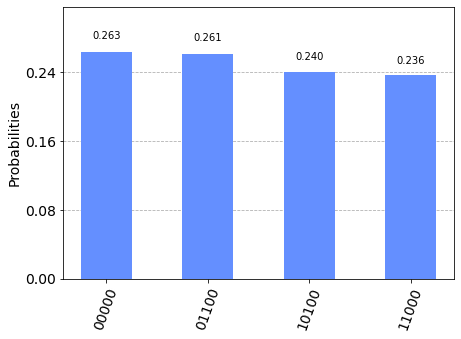

In [645]:
results = j.result()
count = results.get_counts()
plot_histogram(count)

We see that the ancilla qubits are 0 as expected for a perfect execution. We also only obtain a +1 product of all three $X$-basis eigenvalues in qubits `2`-`4`, which is expected for a logical $|+\rangle_L$ state.

## Simulations

We initialize the logical state to 
\begin{align}
    |\psi_0\rangle_L &= e^{-i\phi/2} \cos{(\theta/2)} |0\rangle_L + e^{i\phi/2} \sin{(\theta/2)} |1\rangle_L.
\end{align}

We then sweep over the equatorial ($\theta = \pi/2, \phi \in [0, 2\pi]$) and $xz-$planes ($\theta = \in [0, \pi], \phi = 0$) while measuring $\langle X \rangle_L, \langle Y \rangle_L$, and $\langle Z \rangle_L$.

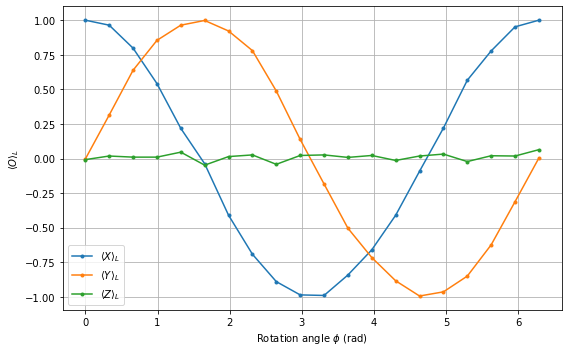

In [538]:
phis = np.linspace(0., 2*np.pi, 20)
sims_eqt = [avg_xs_sim_eqt[0], avg_ys_sim_eqt[0], avg_zs_sim_eqt[0]]
labels = ['$\\langle X \\rangle_L$', '$\\langle Y \\rangle_L$', '$\\langle Z \\rangle_L$']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.title('Simulation')

for i, sim in enumerate(sims_eqt):
    plt.plot(phis, sim, label=labels[i], marker='.')
    plt.xlabel('Rotation angle $\\phi$ (rad)')
    plt.ylabel('$\\langle O \\rangle_L$')

plt.grid()
plt.legend()
plt.tight_layout()

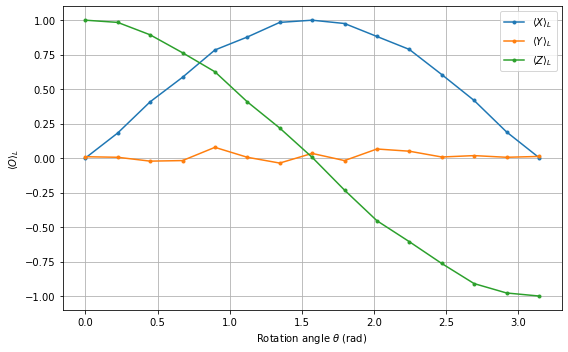

In [539]:
thetas = np.linspace(0., np.pi, 15)
sims = np.array([avg_xs_sim, avg_ys_sim, avg_zs_sim])
labels = ['$\\langle X \\rangle_L$', '$\\langle Y \\rangle_L$', '$\\langle Z \\rangle_L$']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.title('Simulation')

for i, sim in enumerate(sims):
    plt.plot(thetas, sim.T[0], label=labels[i], marker='.')
    plt.xlabel('Rotation angle $\\theta$ (rad)')
    plt.ylabel('$\\langle O \\rangle_L$')

plt.grid()
plt.legend()
plt.tight_layout()

Compared thhe Figs 2c and 2e in Marques et al:

![fig2](fig2.jpg)

## Results from simulations and experiments on Starmon

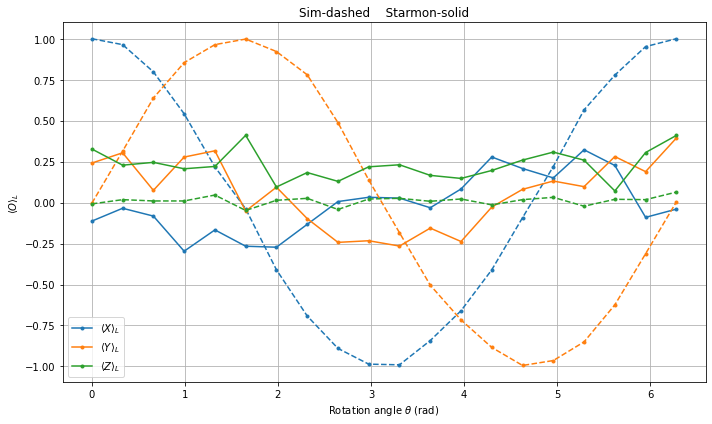

In [668]:
phis = np.linspace(0., 2*np.pi, 20)
sims_eqt = [avg_xs_sim_eqt[0], avg_ys_sim_eqt[0], avg_zs_sim_eqt[0]]
starmons_eqt = [avg_xs_eqt_starmon[0], avg_ys_eqt_starmon[0], avg_zs_eqt_starmon[0]]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['$\\langle X \\rangle_L$', '$\\langle Y \\rangle_L$', '$\\langle Z \\rangle_L$']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title('Sim-dashed    Starmon-solid')

for i, sim in enumerate(sims_eqt):
    plt.plot(phis, sim, color=colors[i], marker='.', ls='--')
    plt.plot(phis, starmons_eqt[i], label=labels[i], color=colors[i], marker='.')
    plt.xlabel('Rotation angle $\\theta$ (rad)')
    plt.ylabel('$\\langle O \\rangle_L$')

plt.grid()
plt.legend()
plt.tight_layout()

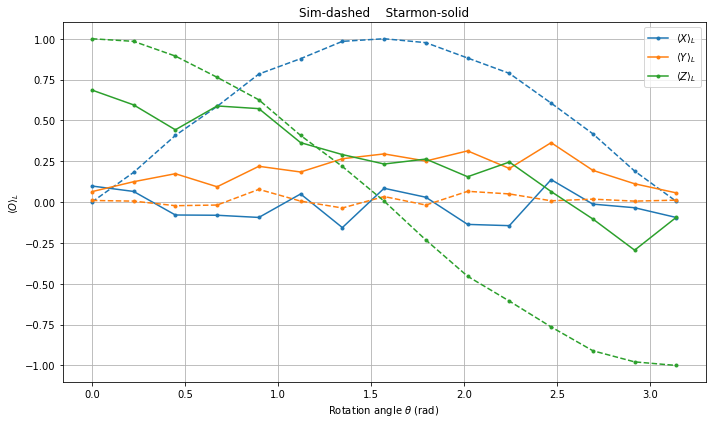

In [666]:
thetas = np.linspace(0., np.pi, 15)
starmons = [avg_xs_starmon, avg_ys_starmon, avg_zs_starmon]
sims = [avg_xs_sim, avg_ys_sim, avg_zs_sim]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['$\\langle X \\rangle_L$', '$\\langle Y \\rangle_L$', '$\\langle Z \\rangle_L$']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title('Sim-dashed    Starmon-solid')

for i, sim in enumerate(sims):
    plt.plot(thetas, sim, color=colors[i], marker='.', ls='--')
    plt.plot(thetas, starmons[i], label=labels[i], color=colors[i], marker='.')
    plt.xlabel('Rotation angle $\\theta$ (rad)')
    plt.ylabel('$\\langle O \\rangle_L$')

plt.grid()
plt.legend()
plt.tight_layout()

## Experiments
## Simulation

### $\langle Z \rangle_L$ measurement

### $\theta = \pi/2, \phi \in [0, 2\pi]$

In [509]:
thetas = [np.pi/2]
phis = np.linspace(0., 2*np.pi, 20)
circs = measure_logical_pauli(thetas, phis, op='z')

In [510]:
# Add QI backend.
qi_backend = QI.get_backend('QX single-node simulator')
#qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [511]:
def map_to_pm1(bitstring):
    out = np.ones(3)
    
    for i, bit in enumerate(bitstring):
        if bit == '1':
            out[i] = -1
            
    return out

In [514]:
# Analyze results.
avg_zs_sim_eqt = []

for i, jobs_theta in enumerate(jobs):
    avg_z_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_z_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg_z = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg_z += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg_z /= pop
            avg_z_runs.append(avg_z)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_z = {avg_z}\n')
            
        avg_z_theta.append(np.mean(avg_z_runs))
    
    avg_zs_sim_eqt.append(avg_z_theta)

theta = 1.5707963267948966, phi = 0.0
Run = 0
{'00000': 496, '11100': 504}
avg_z = -0.008

theta = 1.5707963267948966, phi = 0.3306939635357677
Run = 0
{'00000': 509, '11100': 491}
avg_z = 0.018

theta = 1.5707963267948966, phi = 0.6613879270715354
Run = 0
{'00000': 505, '11100': 495}
avg_z = 0.01

theta = 1.5707963267948966, phi = 0.992081890607303
Run = 0
{'00000': 505, '11100': 495}
avg_z = 0.01

theta = 1.5707963267948966, phi = 1.3227758541430708
Run = 0
{'00000': 523, '11100': 477}
avg_z = 0.046

theta = 1.5707963267948966, phi = 1.6534698176788385
Run = 0
{'00000': 476, '11100': 524}
avg_z = -0.048

theta = 1.5707963267948966, phi = 1.984163781214606
Run = 0
{'00000': 507, '11100': 493}
avg_z = 0.014

theta = 1.5707963267948966, phi = 2.3148577447503738
Run = 0
{'00000': 513, '11100': 487}
avg_z = 0.026

theta = 1.5707963267948966, phi = 2.6455517082861415
Run = 0
{'00000': 479, '11100': 521}
avg_z = -0.042

theta = 1.5707963267948966, phi = 2.9762456718219092
Run = 0
{'00000': 

In [515]:
avg_zs_sim_eqt

[[-0.008,
  0.018,
  0.01,
  0.01,
  0.046,
  -0.048,
  0.014,
  0.026,
  -0.042,
  0.022,
  0.026,
  0.008,
  0.022,
  -0.014,
  0.018,
  0.032,
  -0.022,
  0.02,
  0.018,
  0.064]]

### $\theta \in [0, \pi], \phi = 0$

In [516]:
thetas = np.linspace(0., np.pi, 15)
phis = [0.]
circs = measure_logical_pauli(thetas, phis, op='z')

In [517]:
# Add QI backend.
qi_backend = QI.get_backend('QX single-node simulator')
#qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [518]:
# Analyze results.
avg_zs_sim = []

for i, jobs_theta in enumerate(jobs):
    avg_z_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_z_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg_z = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg_z += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg_z /= pop
            avg_z_runs.append(avg_z)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_z = {avg_z}\n')
            
        avg_z_theta.append(np.mean(avg_z_runs))
    
    avg_zs_sim.append(avg_z_theta)

theta = 0.0, phi = 0.0
Run = 0
{'00000': 1000}
avg_z = 1.0

theta = 0.2243994752564138, phi = 0.0
Run = 0
{'00000': 992, '11100': 8}
avg_z = 0.984

theta = 0.4487989505128276, phi = 0.0
Run = 0
{'00000': 947, '11100': 53}
avg_z = 0.894

theta = 0.6731984257692414, phi = 0.0
Run = 0
{'00000': 882, '11100': 118}
avg_z = 0.764

theta = 0.8975979010256552, phi = 0.0
Run = 0
{'00000': 813, '11100': 187}
avg_z = 0.626

theta = 1.121997376282069, phi = 0.0
Run = 0
{'00000': 704, '11100': 296}
avg_z = 0.408

theta = 1.3463968515384828, phi = 0.0
Run = 0
{'00000': 609, '11100': 391}
avg_z = 0.218

theta = 1.5707963267948966, phi = 0.0
Run = 0
{'00000': 503, '11100': 497}
avg_z = 0.006

theta = 1.7951958020513104, phi = 0.0
Run = 0
{'00000': 384, '11100': 616}
avg_z = -0.232

theta = 2.019595277307724, phi = 0.0
Run = 0
{'00000': 273, '11100': 727}
avg_z = -0.454

theta = 2.243994752564138, phi = 0.0
Run = 0
{'00000': 197, '11100': 803}
avg_z = -0.606

theta = 2.4683942278205517, phi = 0.0
Run =

In [519]:
avg_zs_sim

[[1.0],
 [0.984],
 [0.894],
 [0.764],
 [0.626],
 [0.408],
 [0.218],
 [0.006],
 [-0.232],
 [-0.454],
 [-0.606],
 [-0.764],
 [-0.91],
 [-0.978],
 [-1.0]]

### $\langle X \rangle_L$ measurement

### $\theta = \pi/2, \phi \in [0, 2\pi]$

In [500]:
thetas = [np.pi/2]
phis = np.linspace(0., 2*np.pi, 20)
circs = measure_logical_pauli(thetas, phis, op='x')

In [501]:
# Add QI backend.
qi_backend = QI.get_backend('QX single-node simulator')
#qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [502]:
# Analyze results.
avg_xs_sim_eqt = []

for i, jobs_theta in enumerate(jobs):
    avg_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg /= pop
            avg_runs.append(avg)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_x = {avg}\n')
            
        avg_theta.append(np.mean(avg_runs))
    
    avg_xs_sim_eqt.append(avg_theta)

theta = 1.5707963267948966, phi = 0.0
Run = 0
{'00000': 232, '01100': 261, '10100': 254, '11000': 253}
avg_x = 1.0

theta = 1.5707963267948966, phi = 0.3306939635357677
Run = 0
{'00000': 246, '00100': 9, '01000': 2, '01100': 250, '10000': 3, '10100': 222, '11000': 264, '11100': 4}
avg_x = 0.964

theta = 1.5707963267948966, phi = 0.6613879270715354
Run = 0
{'00000': 219, '00100': 28, '01000': 23, '01100': 234, '10000': 30, '10100': 229, '11000': 217, '11100': 20}
avg_x = 0.798

theta = 1.5707963267948966, phi = 0.992081890607303
Run = 0
{'00000': 179, '00100': 51, '01000': 59, '01100': 190, '10000': 51, '10100': 187, '11000': 215, '11100': 68}
avg_x = 0.542

theta = 1.5707963267948966, phi = 1.3227758541430708
Run = 0
{'00000': 141, '00100': 92, '01000': 113, '01100': 158, '10000': 96, '10100': 168, '11000': 142, '11100': 90}
avg_x = 0.218

theta = 1.5707963267948966, phi = 1.6534698176788385
Run = 0
{'00000': 103, '00100': 117, '01000': 122, '01100': 126, '10000': 136, '10100': 118, '1

In [503]:
avg_xs_sim_eqt

[[1.0,
  0.964,
  0.798,
  0.542,
  0.218,
  -0.038,
  -0.41,
  -0.692,
  -0.89,
  -0.986,
  -0.99,
  -0.842,
  -0.66,
  -0.41,
  -0.092,
  0.22,
  0.566,
  0.778,
  0.952,
  1.0]]

### $\theta \in [0, \pi], \phi = 0$

In [520]:
thetas = np.linspace(0., np.pi, 15)
phis = [0.]
circs = measure_logical_pauli(thetas, phis, op='x')

In [521]:
# Add QI backend.
qi_backend = QI.get_backend('QX single-node simulator')
#qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [522]:
# Analyze results.
avg_xs_sim = []

for i, jobs_theta in enumerate(jobs):
    avg_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg /= pop
            avg_runs.append(avg)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_x = {avg}\n')
            
        avg_theta.append(np.mean(avg_runs))
    
    avg_xs_sim.append(avg_theta)

theta = 0.0, phi = 0.0
Run = 0
{'00000': 129, '00100': 140, '01000': 117, '01100': 131, '10000': 123, '10100': 131, '11000': 109, '11100': 120}
avg_z = 0.0

theta = 0.2243994752564138, phi = 0.0
Run = 0
{'00000': 138, '00100': 84, '01000': 115, '01100': 174, '10000': 115, '10100': 149, '11000': 130, '11100': 95}
avg_z = 0.182

theta = 0.4487989505128276, phi = 0.0
Run = 0
{'00000': 168, '00100': 76, '01000': 80, '01100': 191, '10000': 69, '10100': 184, '11000': 161, '11100': 71}
avg_z = 0.408

theta = 0.6731984257692414, phi = 0.0
Run = 0
{'00000': 172, '00100': 52, '01000': 46, '01100': 211, '10000': 57, '10100': 202, '11000': 208, '11100': 52}
avg_z = 0.586

theta = 0.8975979010256552, phi = 0.0
Run = 0
{'00000': 208, '00100': 21, '01000': 24, '01100': 238, '10000': 33, '10100': 220, '11000': 226, '11100': 30}
avg_z = 0.784

theta = 1.121997376282069, phi = 0.0
Run = 0
{'00000': 227, '00100': 16, '01000': 14, '01100': 218, '10000': 20, '10100': 231, '11000': 263, '11100': 11}
avg_z =

In [523]:
avg_xs_sim

[[0.0],
 [0.182],
 [0.408],
 [0.586],
 [0.784],
 [0.878],
 [0.984],
 [1.0],
 [0.976],
 [0.882],
 [0.788],
 [0.606],
 [0.418],
 [0.19],
 [0.004]]

### $\langle Y \rangle_L$ measurement

### $\theta = \pi/2, \phi \in [0, 2\pi]$

In [504]:
thetas = [np.pi/2]
phis = np.linspace(0., 2*np.pi, 20)
circs = measure_logical_pauli(thetas, phis, op='y')

In [505]:
# Add QI backend.
qi_backend = QI.get_backend('QX single-node simulator')
#qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [507]:
# Analyze results.
avg_ys_sim_eqt = []

for i, jobs_theta in enumerate(jobs):
    avg_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg /= pop
            avg_runs.append(avg)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_x = {avg}\n')
            
        avg_theta.append(np.mean(avg_runs))
    
    avg_ys_sim_eqt.append(avg_theta)

theta = 1.5707963267948966, phi = 0.0
Run = 0
{'00000': 105, '00100': 106, '01000': 136, '01100': 118, '10000': 115, '10100': 132, '11000': 143, '11100': 145}
avg_x = -0.004

theta = 1.5707963267948966, phi = 0.3306939635357677
Run = 0
{'00000': 155, '00100': 91, '01000': 87, '01100': 181, '10000': 88, '10100': 169, '11000': 152, '11100': 77}
avg_x = 0.314

theta = 1.5707963267948966, phi = 0.6613879270715354
Run = 0
{'00000': 212, '00100': 58, '01000': 36, '01100': 197, '10000': 34, '10100': 202, '11000': 208, '11100': 53}
avg_x = 0.638

theta = 1.5707963267948966, phi = 0.992081890607303
Run = 0
{'00000': 234, '00100': 17, '01000': 15, '01100': 249, '10000': 24, '10100': 229, '11000': 215, '11100': 17}
avg_x = 0.854

theta = 1.5707963267948966, phi = 1.3227758541430708
Run = 0
{'00000': 263, '00100': 7, '01000': 6, '01100': 230, '10000': 5, '10100': 230, '11000': 259}
avg_x = 0.964

theta = 1.5707963267948966, phi = 1.6534698176788385
Run = 0
{'00000': 257, '00100': 1, '01100': 255, 

In [508]:
avg_ys_sim_eqt

[[-0.004,
  0.314,
  0.638,
  0.854,
  0.964,
  0.998,
  0.922,
  0.78,
  0.488,
  0.138,
  -0.184,
  -0.504,
  -0.716,
  -0.884,
  -0.994,
  -0.964,
  -0.85,
  -0.624,
  -0.312,
  0.004]]

### $\theta \in [0, \pi], \phi = 0$

In [524]:
thetas = np.linspace(0., np.pi, 15)
phis = [0.]
circs = measure_logical_pauli(thetas, phis, op='y')

In [525]:
# Add QI backend.
qi_backend = QI.get_backend('QX single-node simulator')
#qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [526]:
# Analyze results.
avg_ys_sim = []

for i, jobs_theta in enumerate(jobs):
    avg_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg /= pop
            avg_runs.append(avg)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_y = {avg}\n')
            
        avg_theta.append(np.mean(avg_runs))
    
    avg_ys_sim.append(avg_theta)

theta = 0.0, phi = 0.0
Run = 0
{'00000': 97, '00100': 115, '01000': 131, '01100': 137, '10000': 144, '10100': 134, '11000': 137, '11100': 105}
avg_y = 0.01

theta = 0.2243994752564138, phi = 0.0
Run = 0
{'00000': 125, '00100': 110, '01000': 130, '01100': 112, '10000': 128, '10100': 142, '11000': 124, '11100': 129}
avg_y = 0.006

theta = 0.4487989505128276, phi = 0.0
Run = 0
{'00000': 119, '00100': 130, '01000': 122, '01100': 126, '10000': 124, '10100': 122, '11000': 122, '11100': 135}
avg_y = -0.022

theta = 0.6731984257692414, phi = 0.0
Run = 0
{'00000': 129, '00100': 130, '01000': 125, '01100': 110, '10000': 119, '10100': 122, '11000': 130, '11100': 135}
avg_y = -0.018

theta = 0.8975979010256552, phi = 0.0
Run = 0
{'00000': 122, '00100': 119, '01000': 124, '01100': 133, '10000': 104, '10100': 139, '11000': 145, '11100': 114}
avg_y = 0.078

theta = 1.121997376282069, phi = 0.0
Run = 0
{'00000': 114, '00100': 137, '01000': 104, '01100': 134, '10000': 122, '10100': 118, '11000': 137, '

In [527]:
avg_ys_sim

[[0.01],
 [0.006],
 [-0.022],
 [-0.018],
 [0.078],
 [0.006],
 [-0.036],
 [0.034],
 [-0.018],
 [0.066],
 [0.05],
 [0.008],
 [0.018],
 [0.006],
 [0.012]]

## Starmon-5

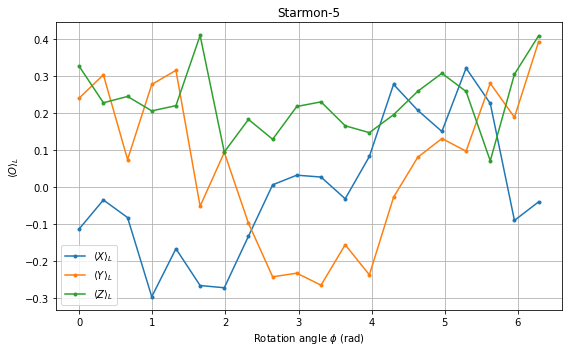

In [657]:
phis = np.linspace(0., 2*np.pi, 20)
starmons_eqt = [avg_xs_eqt_starmon[0], avg_ys_eqt_starmon[0], avg_zs_eqt_starmon[0]]
labels = ['$\\langle X \\rangle_L$', '$\\langle Y \\rangle_L$', '$\\langle Z \\rangle_L$']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Starmon-5')

for i, sim in enumerate(starmons_eqt):
    plt.plot(phis, sim, label=labels[i], marker='.')
    plt.xlabel('Rotation angle $\\phi$ (rad)')
    plt.ylabel('$\\langle O \\rangle_L$')

plt.grid()
plt.legend()
plt.tight_layout()

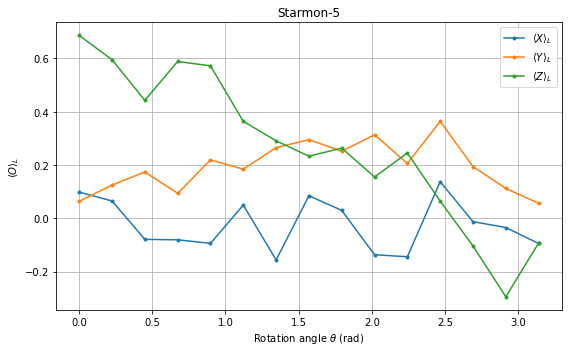

In [658]:
thetas = np.linspace(0., np.pi, 15)
starmons = [avg_xs_starmon, avg_ys_starmon, avg_zs_starmon]
labels = ['$\\langle X \\rangle_L$', '$\\langle Y \\rangle_L$', '$\\langle Z \\rangle_L$']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Starmon-5')

for i, sim in enumerate(starmons):
    plt.plot(thetas, sim, label=labels[i], marker='.')
    plt.xlabel('Rotation angle $\\theta$ (rad)')
    plt.ylabel('$\\langle O \\rangle_L$')

plt.grid()
plt.legend()
plt.tight_layout()

### $\langle Z \rangle_L$ measurement

### $\theta = \pi/2, \phi \in [0, 2\pi]$

In [540]:
thetas = [np.pi/2]
phis = np.linspace(0., 2*np.pi, 20)
circs = measure_logical_pauli(thetas, phis, op='z')

In [541]:
# Add QI backend.
#qi_backend = QI.get_backend('QX single-node simulator')
qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [542]:
# Analyze results.
avg_zs_eqt_starmon = []

for i, jobs_theta in enumerate(jobs):
    avg_z_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_z_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg_z = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg_z += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg_z /= pop
            avg_z_runs.append(avg_z)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_z = {avg_z}\n')
            
        avg_z_theta.append(np.mean(avg_z_runs))
    
    avg_zs_eqt_starmon.append(avg_z_theta)

theta = 1.5707963267948966, phi = 0.0
Run = 0
{'00000': 267, '00001': 61, '00010': 33, '00011': 6, '00100': 18, '00101': 19, '00110': 6, '00111': 4, '01000': 24, '01001': 20, '01010': 6, '01011': 11, '01100': 17, '01101': 49, '01110': 4, '01111': 9, '10000': 22, '10001': 34, '10010': 14, '10011': 20, '10100': 30, '10101': 22, '10110': 7, '10111': 17, '11000': 31, '11001': 14, '11010': 27, '11011': 12, '11100': 111, '11101': 38, '11110': 28, '11111': 19}
avg_z = 0.3269230769230769

theta = 1.5707963267948966, phi = 0.3306939635357677
Run = 0
{'00000': 243, '00001': 35, '00010': 32, '00011': 13, '00100': 11, '00101': 19, '00110': 3, '00111': 15, '01000': 51, '01001': 33, '01010': 10, '01011': 17, '01100': 27, '01101': 56, '01110': 5, '01111': 16, '10000': 31, '10001': 38, '10010': 3, '10011': 10, '10100': 8, '10101': 22, '10110': 4, '10111': 29, '11000': 42, '11001': 22, '11010': 20, '11011': 18, '11100': 108, '11101': 32, '11110': 17, '11111': 10}
avg_z = 0.22840690978886757

theta = 1.

In [543]:
avg_zs_eqt_starmon

[[0.3269230769230769,
  0.22840690978886757,
  0.24545454545454545,
  0.20642201834862386,
  0.22053231939163498,
  0.4105263157894737,
  0.0951276102088167,
  0.18329466357308585,
  0.12956810631229235,
  0.21834862385321102,
  0.23076923076923078,
  0.16612377850162866,
  0.14746543778801843,
  0.196,
  0.25942350332594233,
  0.3081395348837209,
  0.2589073634204275,
  0.07114624505928854,
  0.30560578661844484,
  0.40992167101827676]]

### $\theta \in [0, \pi], \phi = 0$

In [544]:
thetas = np.linspace(0., np.pi, 15)
phis = [0.]
circs = measure_logical_pauli(thetas, phis, op='z')

In [545]:
# Add QI backend.
#qi_backend = QI.get_backend('QX single-node simulator')
qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [546]:
# Analyze results.
avg_zs_starmon = []

for i, jobs_theta in enumerate(jobs):
    avg_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg /= pop
            avg_runs.append(avg)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_z = {avg}\n')
            
        avg_theta.append(np.mean(avg_runs))
    
    avg_zs_starmon.append(avg_theta)

theta = 0.0, phi = 0.0
Run = 0
{'00000': 467, '00001': 71, '00010': 104, '00011': 30, '00100': 12, '00101': 2, '00110': 10, '00111': 1, '01000': 38, '01001': 30, '01010': 13, '01011': 26, '01101': 2, '01110': 1, '01111': 2, '10000': 36, '10001': 59, '10010': 20, '10011': 30, '10100': 1, '10101': 2, '10110': 1, '10111': 1, '11000': 10, '11001': 13, '11010': 6, '11011': 2, '11100': 3, '11101': 1, '11110': 3, '11111': 3}
avg_z = 0.6860670194003528

theta = 0.2243994752564138, phi = 0.0
Run = 0
{'00000': 445, '00001': 77, '00010': 74, '00011': 36, '00100': 53, '00101': 17, '00110': 14, '00111': 17, '01000': 14, '01001': 3, '01010': 3, '01011': 5, '01100': 2, '01101': 1, '01111': 2, '10000': 49, '10001': 81, '10010': 13, '10011': 31, '10100': 7, '10101': 20, '10110': 9, '10111': 11, '11000': 3, '11001': 4, '11010': 1, '11011': 2, '11101': 2, '11110': 1, '11111': 3}
avg_z = 0.5951134380453752

theta = 0.4487989505128276, phi = 0.0
Run = 0
{'00000': 365, '00001': 60, '00010': 74, '00011': 18,

In [548]:
avg_zs_starmon

[[0.6860670194003528],
 [0.5951134380453752],
 [0.4426229508196721],
 [0.5885416666666666],
 [0.5720930232558139],
 [0.3639344262295082],
 [0.2908704883227176],
 [0.23316062176165803],
 [0.26345609065155806],
 [0.15527950310559005],
 [0.24521072796934865],
 [0.06461538461538462],
 [-0.10344827586206896],
 [-0.29411764705882354],
 [-0.09273182957393483]]

### $\langle X \rangle_L$ measurement

### $\theta = \pi/2, \phi \in [0, 2\pi]$

In [680]:
thetas = [np.pi/2]
phis = np.linspace(0., 2*np.pi, 20)
#phis = [0]
circs = measure_logical_pauli(thetas, phis, op='x')

from itertools import combinations
pairs = combinations(range(5), 2)

In [682]:
# Add QI backend.
#qi_backend = QI.get_backend('QX single-node simulator')
qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            try:
                j = execute(circ, backend=qi_backend, shots=shots)
                
            except:
                print('error')
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

error
error
error
error
error
error
error
error
error
error
error
error
error
error
error


In [ ]:
# Analyze results.
avg_xs_eqt_starmon = []

for pair in pairs:
    avg_xs_eqt_starmon_pair = []
    
    for i, jobs_theta in enumerate(jobs):
        avg_theta = []

        for k, jobs_phi in enumerate(jobs_theta):
            print(f'theta = {thetas[i]}, phi = {phis[k]}')

            # Loop over runs.
            avg_runs = []
            for l, j in enumerate(jobs_phi):
                result = j.result()
                counts = result.get_counts()
                plot_histogram(counts)
                avg = 0
                pop = 0

                # In a single run.
                for bitstring in counts:
                    if bitstring[pair[0]] + bitstring[pair[1]] == '00': # Postselect.
                        _bitstring = map_to_pm1(bitstring[:3])
                        #print(bitstring)
                        #print(_bitstring)
                        #print(prod)
                        prod = np.prod(_bitstring)
                        avg += prod * counts[bitstring]
                        pop += counts[bitstring]

                avg /= pop
                avg_runs.append(avg)
                print(f'Run = {l}')
                print(counts)
                print(f'avg_x = {avg}\n')

            avg_theta.append(np.mean(avg_runs))

        avg_xs_eqt_starmon_pair.append(avg_theta)
    
    avg_xs_eqt_starmon.append(avg_xs_eqt_starmon_pair)

In [560]:
avg_xs_eqt_starmon

[[-0.11294765840220386,
  -0.034666666666666665,
  -0.08235294117647059,
  -0.2966101694915254,
  -0.16666666666666666,
  -0.26627218934911245,
  -0.27230046948356806,
  -0.13274336283185842,
  0.006342494714587738,
  0.032397408207343416,
  0.0273224043715847,
  -0.031446540880503145,
  0.0830945558739255,
  0.2781456953642384,
  0.2079646017699115,
  0.1506849315068493,
  0.3221601489757914,
  0.2265193370165746,
  -0.09006928406466513,
  -0.039832285115303984]]

### $\theta \in [0, \pi], \phi = 0$

In [561]:
thetas = np.linspace(0., np.pi, 15)
phis = [0.]
circs = measure_logical_pauli(thetas, phis, op='x')

In [562]:
# Add QI backend.
#qi_backend = QI.get_backend('QX single-node simulator')
qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [571]:
# Analyze results.
avg_xs_starmon = []

for i, jobs_theta in enumerate(jobs):
    avg_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg /= pop
            avg_runs.append(avg)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_x = {avg}\n')
            
        avg_theta.append(np.mean(avg_runs))
    
    avg_xs_starmon.append(avg_theta)

theta = 0.0, phi = 0.0
Run = 0
{'00000': 99, '00001': 33, '00010': 30, '00011': 20, '00100': 38, '00101': 24, '00110': 15, '00111': 8, '01000': 67, '01001': 26, '01010': 27, '01011': 15, '01100': 34, '01101': 26, '01110': 13, '01111': 11, '10000': 79, '10001': 42, '10010': 61, '10011': 28, '10100': 50, '10101': 23, '10110': 27, '10111': 10, '11000': 68, '11001': 23, '11010': 28, '11011': 17, '11100': 22, '11101': 9, '11110': 15, '11111': 12}
avg_x = 0.09846827133479212

theta = 0.2243994752564138, phi = 0.0
Run = 0
{'00000': 83, '00001': 34, '00010': 38, '00011': 29, '00100': 34, '00101': 11, '00110': 18, '00111': 8, '01000': 84, '01001': 35, '01010': 36, '01011': 30, '01100': 34, '01101': 20, '01110': 14, '01111': 12, '10000': 68, '10001': 28, '10010': 35, '10011': 27, '10100': 38, '10101': 11, '10110': 12, '10111': 9, '11000': 98, '11001': 16, '11010': 38, '11011': 28, '11100': 36, '11101': 9, '11110': 13, '11111': 14}
avg_x = 0.06526315789473684

theta = 0.4487989505128276, phi = 0.

In [566]:
avg_xs_starmon

[[0.18352059925093633],
 [0.10588235294117647],
 [0.015151515151515152],
 [-0.08196721311475409],
 [-0.007246376811594203],
 [0.19741100323624594],
 [-0.06153846153846154],
 [0.033707865168539325],
 [-0.1037037037037037],
 [-0.007042253521126761],
 [-0.13588850174216027],
 [0.08403361344537816],
 [-0.004219409282700422],
 [0.044673539518900345],
 [-0.007936507936507936]]

### $\langle Y \rangle_L$ measurement

### $\theta = \pi/2, \phi \in [0, 2\pi]$

In [647]:
thetas = [np.pi/2]
phis = np.linspace(0., 2*np.pi, 20)
circs = measure_logical_pauli(thetas, phis, op='y')

In [648]:
# Add QI backend.
#qi_backend = QI.get_backend('QX single-node simulator')
qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [649]:
# Analyze results.
avg_ys_eqt_starmon = []

for i, jobs_theta in enumerate(jobs):
    avg_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg /= pop
            avg_runs.append(avg)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_x = {avg}\n')
            
        avg_theta.append(np.mean(avg_runs))
    
    avg_ys_eqt_starmon.append(avg_theta)

theta = 1.5707963267948966, phi = 0.0
Run = 0
{'00000': 93, '00001': 35, '00010': 47, '00011': 18, '00100': 21, '00101': 18, '00110': 24, '00111': 19, '01000': 45, '01001': 19, '01010': 20, '01011': 11, '01100': 33, '01101': 39, '01110': 20, '01111': 10, '10000': 52, '10001': 38, '10010': 34, '10011': 17, '10100': 46, '10101': 33, '10110': 38, '10111': 30, '11000': 57, '11001': 23, '11010': 42, '11011': 37, '11100': 22, '11101': 20, '11110': 28, '11111': 11}
avg_x = 0.24119241192411925

theta = 1.5707963267948966, phi = 0.3306939635357677
Run = 0
{'00000': 100, '00001': 58, '00010': 23, '00011': 16, '00100': 47, '00101': 27, '00110': 12, '00111': 11, '01000': 38, '01001': 40, '01010': 11, '01011': 12, '01100': 60, '01101': 43, '01110': 12, '01111': 17, '10000': 43, '10001': 45, '10010': 18, '10011': 13, '10100': 67, '10101': 47, '10110': 17, '10111': 21, '11000': 69, '11001': 48, '11010': 13, '11011': 14, '11100': 30, '11101': 13, '11110': 5, '11111': 10}
avg_x = 0.3039647577092511

th

In [652]:
avg_ys_eqt_starmon

[[0.24119241192411925,
  0.3039647577092511,
  0.07471264367816093,
  0.27790973871733965,
  0.31610337972166996,
  -0.051685393258426963,
  0.09404990403071017,
  -0.09762532981530343,
  -0.2427536231884058,
  -0.2328159645232816,
  -0.2653061224489796,
  -0.1558073654390935,
  -0.23745819397993312,
  -0.027253668763102725,
  0.08085106382978724,
  0.13157894736842105,
  0.0972972972972973,
  0.2809917355371901,
  0.18895966029723993,
  0.3939393939393939]]

### $\theta \in [0, \pi], \phi = 0$

In [653]:
thetas = np.linspace(0., np.pi, 15)
phis = [0.]
circs = measure_logical_pauli(thetas, phis, op='y')

In [654]:
# Add QI backend.
#qi_backend = QI.get_backend('QX single-node simulator')
qi_backend = QI.get_backend('Starmon-5')

# Execute jobs.
runs = 1
shots = 1000
jobs = []

for circs_theta in circs:
    jobs_theta = []
    
    for circ in circs_theta:
        jobs_phi = []
        
        for run in range(runs):
            j = execute(circ, backend=qi_backend, shots=shots)
            jobs_phi.append(j)
            
        jobs_theta.append(jobs_phi)
        
    jobs.append(jobs_theta)

In [655]:
# Analyze results.
avg_ys_starmon = []

for i, jobs_theta in enumerate(jobs):
    avg_theta = []
    
    for k, jobs_phi in enumerate(jobs_theta):
        print(f'theta = {thetas[i]}, phi = {phis[k]}')
        
        # Loop over runs.
        avg_runs = []
        for l, j in enumerate(jobs_phi):
            result = j.result()
            counts = result.get_counts()
            plot_histogram(counts)
            avg = 0
            pop = 0
            
            # In a single run.
            for bitstring in counts:
                if bitstring[-2:] == '00': # Postselect.
                    _bitstring = map_to_pm1(bitstring[:3])
                    #print(bitstring)
                    #print(_bitstring)
                    #print(prod)
                    prod = np.prod(_bitstring)
                    avg += prod * counts[bitstring]
                    pop += counts[bitstring]
            
            avg /= pop
            avg_runs.append(avg)
            print(f'Run = {l}')
            print(counts)
            print(f'avg_x = {avg}\n')
            
        avg_theta.append(np.mean(avg_runs))
    
    avg_ys_starmon.append(avg_theta)

theta = 0.0, phi = 0.0
Run = 0
{'00000': 83, '00001': 46, '00010': 22, '00011': 23, '00100': 56, '00101': 42, '00110': 10, '00111': 22, '01000': 45, '01001': 63, '01010': 25, '01011': 16, '01100': 53, '01101': 32, '01110': 12, '01111': 11, '10000': 69, '10001': 45, '10010': 25, '10011': 21, '10100': 50, '10101': 26, '10110': 8, '10111': 14, '11000': 47, '11001': 36, '11010': 15, '11011': 13, '11100': 35, '11101': 17, '11110': 8, '11111': 10}
avg_x = 0.0639269406392694

theta = 0.2243994752564138, phi = 0.0
Run = 0
{'00000': 125, '00001': 32, '00010': 22, '00011': 12, '00100': 61, '00101': 18, '00110': 21, '00111': 7, '01000': 79, '01001': 35, '01010': 25, '01011': 17, '01100': 63, '01101': 28, '01110': 16, '01111': 6, '10000': 68, '10001': 34, '10010': 23, '10011': 17, '10100': 61, '10101': 25, '10110': 19, '10111': 11, '11000': 53, '11001': 23, '11010': 15, '11011': 12, '11100': 27, '11101': 24, '11110': 12, '11111': 9}
avg_x = 0.12476722532588454

theta = 0.4487989505128276, phi = 0.

In [656]:
avg_ys_starmon

[[0.0639269406392694],
 [0.12476722532588454],
 [0.1737704918032787],
 [0.09381237524950099],
 [0.21914357682619648],
 [0.1843137254901961],
 [0.26548672566371684],
 [0.2949907235621521],
 [0.2515090543259557],
 [0.3135011441647597],
 [0.20588235294117646],
 [0.36382536382536385],
 [0.19434628975265017],
 [0.1122715404699739],
 [0.056179775280898875]]